In [72]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import concurrent.futures

from enum import Enum
from tqdm import tqdm
from pyDOE import lhs

import warnings
warnings.filterwarnings('ignore')

In [73]:
def divide_frame_into_rectangles_with_means_and_binarization(
    data, 
    additional_data, 
    num_rects_x, 
    num_rects_y, 
    show_plot=False,
    threshold=0.5,
    use_mean_of_frame=True,
    use_smallest_frames_mean=True,
    crop=True
):
    if not np.iscomplexobj(additional_data):
        warnings.warn("The additional data is not of a complex type. Results might not be accurate.")

    frames_with_rects = []
    cropped_binarized_frames = []
    cropped_additional_frames = []

    min_height, min_width = float('inf'), float('inf')

    if use_mean_of_frame and use_smallest_frames_mean:
        smallest_mean_threshold = min(np.mean(frame) for frame in data)
    else:
        smallest_mean_threshold = None

    for frame_idx, (frame, additional_frame) in enumerate(zip(data, additional_data)):
        height, width = frame.shape
        rect_width = width // num_rects_x
        rect_height = height // num_rects_y

        binarized_frame = np.zeros_like(frame, dtype=np.uint8)
        annotated_frame = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

        if use_mean_of_frame:
            frame_mean = smallest_mean_threshold if use_smallest_frames_mean else np.mean(frame)
        else:
            frame_mean = threshold

        start_col = width
        for row in range(height):
            white_pixels = np.where(frame[row] > np.mean(frame))[0]
            if white_pixels.size > 0:
                start_col = min(start_col, white_pixels[0])
        if start_col >= width:
            start_col = 0

        new_width = width - start_col
        new_num_rects_x = new_width // rect_width

        start_row = 0
        for col in range(width):
            white_pixels = np.where(frame[:, col] > np.mean(frame))[0]
            if white_pixels.size > 0:
                start_row = min(start_row, white_pixels[0])
        if start_row >= height:
            start_row = 0

        new_height = height - start_row
        new_num_rects_y = new_height // rect_height

        for i in range(new_num_rects_y):
            for j in range(new_num_rects_x):
                top_left = (start_col + j * rect_width, start_row + i * rect_height)
                bottom_right = (start_col + (j + 1) * rect_width, start_row + (i + 1) * rect_height)

                rect = frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
                mean_val = np.mean(rect)

                binarized_value = 1 if mean_val >= frame_mean else 0
                binarized_frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = binarized_value

                cv2.rectangle(annotated_frame, top_left, bottom_right, (0, 255, 0), 2)
                text_position = (top_left[0] + 5, top_left[1] + 15)
                cv2.putText(annotated_frame, f"{mean_val:.2f}", text_position, 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

        if crop and frame.shape != additional_frame.shape:
            cropped_binarized = binarized_frame[start_row:start_row + new_num_rects_y * rect_height, 
                                                start_col:start_col + new_num_rects_x * rect_width]
            cropped_additional = additional_frame[start_row:start_row + new_num_rects_y * rect_height, 
                                                  start_col:start_col + new_num_rects_x * rect_width]
        else:
            cropped_binarized = binarized_frame
            cropped_additional = additional_frame

        min_height = min(min_height, cropped_binarized.shape[0])
        min_width = min(min_width, cropped_binarized.shape[1])

        cropped_binarized_frames.append(cropped_binarized)
        cropped_additional_frames.append(cropped_additional)
        frames_with_rects.append(annotated_frame)

        if show_plot:
            plt.figure(figsize=(30, 8))

            plt.subplot(1, 5, 1)
            plt.title(f"Original Frame {frame_idx + 1}")
            plt.imshow(frame, cmap="viridis")
            plt.axis("off")

            plt.subplot(1, 5, 2)
            plt.title(f"Annotated Frame {frame_idx + 1} (Grid + Means)")
            plt.imshow(annotated_frame)
            plt.axis("off")

            plt.subplot(1, 5, 3)
            plt.title(f"Binarized Frame {frame_idx + 1} (Threshold: {frame_mean:.2f})")
            plt.imshow(binarized_frame, cmap="gray")
            plt.axis("off")

            plt.subplot(1, 5, 4)
            plt.title(f"Cropped Region (Frame {frame_idx + 1})")
            plt.imshow(cropped_binarized, cmap="gray")
            plt.axis("off")

            plt.subplot(1, 5, 5)
            plt.title(f"Additional Data ROI (Frame {frame_idx + 1})")
            plt.imshow((cropped_additional.real * cropped_additional.imag), cmap="viridis")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

    cropped_binarized_frames = np.array([r[:min_height, :min_width] for r in cropped_binarized_frames])
    cropped_additional_frames = np.array([r[:min_height, :min_width] for r in cropped_additional_frames])

    return cropped_binarized_frames, cropped_additional_frames

In [74]:
def create_video_from_ndarrays(
    input_data1, 
    input_data2, 
    output_path, 
    video_file_name, 
    fps=30,
    enable_vmin_vmax=False, 
    title_1="Video 1", 
    title_2="Video 2"
):
    """Creates a video from two 3D numpy arrays of frames, saving it to the specified output path with a given filename."""
    
    def prepare_ndarray_frame(data1, data2, vmin1, vmax1, vmin2, vmax2):
        """Prepares a frame from two numpy arrays for video by plotting them side by side with colorbars and titles."""
        fig, axes = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [10, 10], 'wspace': 0.2})

        axes[0].set_title(title_1, fontsize=12, pad=10)
        axes[1].set_title(title_2, fontsize=12, pad=10)

        im1 = axes[0].imshow(data1, origin='lower', aspect='equal', 
                             vmin=vmin1 if enable_vmin_vmax else None, 
                             vmax=vmax1 if enable_vmin_vmax else None)
        im2 = axes[1].imshow(data2, origin='lower', aspect='equal', 
                             vmin=vmin2 if enable_vmin_vmax else None, 
                             vmax=vmax2 if enable_vmin_vmax else None)

        cbar1 = fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.02)
        cbar1.ax.tick_params(labelsize=8)
        cbar1.ax.set_aspect(20)

        cbar2 = fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.02)
        cbar2.ax.tick_params(labelsize=8)
        cbar2.ax.set_aspect(20)

        for ax in axes:
            ax.invert_yaxis()
            ax.axis('off')

        fig.tight_layout()
        fig.canvas.draw()

        width, height = fig.canvas.get_width_height()
        image = np.asarray(fig.canvas.buffer_rgba())[:, :, :3]
        plt.close(fig)
        return image

    def process_ndarray_frame(args):
        """Processes a frame by preparing it with given vmin and vmax values."""
        frame1, frame2, vmin1, vmax1, vmin2, vmax2 = args
        return prepare_ndarray_frame(frame1, frame2, vmin1, vmax1, vmin2, vmax2)
    
    if not os.path.exists(output_path):
        print(f"Output directory has been created: {output_path}")
        os.makedirs(output_path)

    if input_data1.ndim != 3 or input_data2.ndim != 3:
        raise ValueError("Both input arrays must be 3-dimensional (frames, width, height).")

    if not video_file_name.lower().endswith(".mp4"):
        video_file_name += ".mp4"

    video_path = os.path.join(output_path, video_file_name)

    vmin1, vmax1 = input_data1.min(), input_data1.max()
    vmin2, vmax2 = input_data2.min(), input_data2.max()

    first_frame_image = prepare_ndarray_frame(input_data1[0], input_data2[0], vmin1, vmax1, vmin2, vmax2)
    height, width = first_frame_image.shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

    args = [(frame1, frame2, vmin1, vmax1, vmin2, vmax2) for frame1, frame2 in zip(input_data1, input_data2)]

    try:
        with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
            frames = list(tqdm(executor.map(process_ndarray_frame, args), total=len(input_data1), desc="Creating video"))
            for video_frame in frames:
                video_writer.write(cv2.cvtColor(video_frame, cv2.COLOR_RGB2BGR))
        video_writer.release()
    except Exception as e:
        video_writer.release()
        raise RuntimeError(f"Failed to create video: {e}")

In [75]:
class PlotType(Enum):
    REAL       = "real"
    IMAG       = "imag"
    ABS        = "abs"
    ANGLE      = "angle"
    REAL_IMAG  = "real_imag"
    UNCHANGED  = "unchanged"
    ABS_SQUARE = "abs_square"


class PlotBuilder:
    def __init__(self):
        self.fig, self.axes = None, None
        self.plots = []

    def set_grid(self, rows, cols):
        self.fig, self.axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
        self.axes = self.axes.flatten() if rows * cols > 1 else [self.axes]
        return self

    def add_plot(self, index, data, plot_type=PlotType.UNCHANGED, **kwargs):
        if self.fig is None or self.axes is None:
            raise ValueError("Grid is not set. Use set_grid(rows, cols) first.")

        if index >= len(self.axes):
            raise IndexError("Index exceeds the number of grid cells.")

        ax = self.axes[index]
        image_kwargs = {k: v for k, v in kwargs.items() if k not in ["xlabel", "ylabel", "title", "colorbar", "annotations"]}
        img = self._generate_image(ax, data, plot_type, **image_kwargs)

        self._apply_axes_settings(ax, **kwargs)
        self._apply_special_settings(ax, img, **kwargs)

        self.plots.append((index, data, plot_type, kwargs))
        return self

    def _generate_image(self, ax, data, plot_type, **kwargs):
        plot_actions = {
            PlotType.UNCHANGED:  lambda: ax.imshow(data, **kwargs),
            PlotType.REAL:       lambda: ax.imshow(data.real, **kwargs),
            PlotType.IMAG:       lambda: ax.imshow(data.imag, **kwargs),
            PlotType.ABS:        lambda: ax.imshow(np.abs(data), **kwargs),
            PlotType.ANGLE:      lambda: ax.imshow(np.angle(data), **kwargs),
            PlotType.REAL_IMAG:  lambda: ax.imshow(data.imag * data.real, **kwargs),
            PlotType.ABS_SQUARE: lambda: ax.imshow(np.abs(data) ** 2, **kwargs)
        }

        if plot_type not in plot_actions:
            valid_types = ", ".join([pt.value for pt in PlotType])
            raise ValueError(f"Unsupported plot_type. Use PlotType enum values: {valid_types}.")

        return plot_actions[plot_type]()

    def _apply_axes_settings(self, ax, **kwargs):
        for key, value in kwargs.items():
            if key in ["xlabel", "ylabel", "title"]:
                getattr(ax, f"set_{key}")(value)

    def _apply_special_settings(self, ax, img, **kwargs):
        if "colorbar" in kwargs and kwargs["colorbar"]:
            self.fig.colorbar(img, ax=ax)

        if "annotations" in kwargs and isinstance(kwargs["annotations"], list):
            for annotation in kwargs["annotations"]:
                ax.annotate(
                    annotation.get("text", ""),
                    xy=annotation.get("xy", (0, 0)),
                    xytext=annotation.get("xytext", None),
                    arrowprops=annotation.get("arrowprops", None),
                    **annotation.get("kwargs", {})
                )

    def build(self):
        empty_axes = [ax for ax in self.axes if not ax.has_data()]
        for ax in empty_axes:
            ax.remove()

        self.axes = [ax for ax in self.axes if ax in self.fig.axes]
        plt.tight_layout()
        return self.fig, self.axes


In [76]:
class Simulation:
    """
    A class to simulate a dynamical system involving nonlinear operations on a spatial grid using Fourier transforms.

    Attributes:
        dt, dx, dy (float): Temporal and spatial step sizes.
        Nx, Ny, Nt (int): Number of grid points in the x, y dimensions and time steps.
        myu_size (tuple): Shape of the small-scale noise matrix.
        myu_mstd (tuple): Mean and standard deviation for the normal distribution of the noise.
        exponent (ndarray): Precomputed exponential term used in the Fourier transform.
        step1 (ndarray): Precomputed term used in the nonlinear transformation step.
    """

    def __init__(self, d=(0.01, 100/320, 100/320), N=(100, 320, 320), myu_size=(10, 2, 2), myu_mstd=(5.4, 0.8)):
        """
        Initializes the simulation parameters and precomputes necessary Fourier transform terms.

        Args:
            d (tuple): Time step and spatial step sizes (dt, dx, dy).
            N (tuple): Number of time steps and spatial grid points (Nt, Nx, Ny).
            myu_size (tuple): Dimensions of the small-scale initial condition matrix.
            myu_mstd (tuple): Mean and standard deviation for the noise distribution (mean, std).
        """
        self.dt, self.dx, self.dy = d
        self.Nt, self.Nx, self.Ny = N
        self.myu_size = myu_size
        self.myu_mstd = myu_mstd
        
        kx = np.fft.fftfreq(self.Nx, self.dx)
        ky = np.fft.fftfreq(self.Ny, self.dy)
        Kx, Ky = np.meshgrid(kx, ky, indexing='ij')
        q = 10**-6 - 4.0 * np.pi**2 * (Kx**2 + Ky**2)
        self.exponent = np.exp(q * self.dt)
        expm1 = np.expm1(q * self.dt)
        self.q = q
        self.step1 = expm1 / q
        self.step2 = (expm1 - self.dt*q) / (self.dt*(q**2))


    def non_linear_function(self, xx, yy):
        """Defines the nonlinear interaction in the system."""
        return xx * (yy - np.abs(xx)**2)


    def next_state(self, A, myu, order = 2):
        """Computes the next state of the system using the nonlinear transformation."""
        A_hat = np.fft.fft2(A)
        N_hat = np.fft.fft2(self.non_linear_function(A, myu))

        if order == 1 or "N_hat_prev" not in dir(self):
            self.N_hat_prev = N_hat
            return np.fft.ifft2(A_hat*self.exponent + N_hat*self.step1) 

        R = np.fft.ifft2(A_hat*self.exponent + N_hat*self.step1 - (N_hat - self.N_hat_prev)*self.step2*.01) 
        self.N_hat_prev = N_hat
        return R
    
    def compute_myu(self):
        myu_small = np.random.normal(*self.myu_mstd, size=self.myu_size)
        myu_small = (myu_small > 0).astype(np.float32) * 255.0

        scale = np.array((self.Nt, self.Nx, self.Ny)) // np.array(self.myu_size)
        myu = np.kron(myu_small, np.ones(scale))
        return myu


    def compute_state(self, myu):
        """Simulates the system over time, generating the state matrix."""
        A_0 = np.random.normal(size=(self.Nx, self.Ny)) * 0.01 + \
              np.random.normal(size=(self.Nx, self.Ny)) * 0.01j
        A = np.zeros([self.Nt, self.Nx, self.Ny], dtype=np.complex64)
        A[0] = A_0
        
        for i in tqdm(range(1, self.Nt), desc="Computing States"):
            A[i] = self.next_state(A[i - 1], myu[i - 1])
        return A

    
    def compute(self):
        """Main method to compute the simulation."""
        myu = self.compute_myu()
        state = self.compute_state(myu)
        return state, myu


    def check_properties(self, A, myu):
        """Prints properties of the matrices A and myu to ensure correctness and stability."""
        print("Unique Myus count\t", np.count_nonzero(np.unique(myu)))
        unique_values, counts = np.unique(myu, return_counts=True)
        print("Max value of myu:\t", np.max(myu))
        print("Min value of myu:\t", np.min(myu))
        print("Unique values:", unique_values.tolist())
        print("Counts:\t\t", counts)
        print(f"A.shape={A.shape},\nMyu.shape={myu.shape},\n")
        print("Any NaN values in Myu\t\t", np.isnan(myu).any())
        print("Any NaN values in A\t\t", np.isnan(A).any())


In [77]:
def plot_state_and_myu(state, myu, index):

    builder = PlotBuilder()
    (_, _) = (
        builder
        .set_grid(2, 3)
        .add_plot(
                    index = 0, 
                    data = state[index - 1], 
                    plot_type=PlotType.IMAG,
                    title=r"$\Im\{A\}$",    
                    xlabel="X-axis", 
                    ylabel="Y-axis", 
                    cmap="viridis", 
                    colorbar=True
        )
        .add_plot(
                    index = 1, 
                    data = state[index - 1], 
                    plot_type=PlotType.REAL, 
                    title=r"$\Re\{A\}$",    
                    xlabel="X-axis", 
                    ylabel="Y-axis", 
                    cmap="viridis", 
                    colorbar=True
        )
        .add_plot(
                    index = 2, 
                    data = state[index - 1], 
                    plot_type=PlotType.REAL_IMAG,
                    title=r"$\Re\{A\} \times \Im\{A\}$",    
                    xlabel="X-axis", 
                    ylabel="Y-axis", 
                    cmap="viridis", 
                    colorbar=True
        )
        .add_plot(
                    index = 3, 
                    data = state[index - 1], 
                    plot_type=PlotType.ABS_SQUARE,
                    title=r"$|A|^2$",    
                    xlabel="X-axis", 
                    ylabel="Y-axis", 
                    cmap="viridis", 
                    colorbar=True
        )
        .add_plot(
                    index = 4, 
                    data = state[index - 1], 
                    plot_type=PlotType.ANGLE,
                    title=r"$\phi$",    
                    xlabel="X-axis", 
                    ylabel="Y-axis", 
                    cmap="viridis", 
                    colorbar=True
        )
        .add_plot(
                    index = 5, 
                    data = myu[index - 1], 
                    plot_type=PlotType.UNCHANGED,
                    title=r"$\mu$",  
                    xlabel="X-axis", 
                    ylabel="Y-axis", 
                    cmap="viridis", 
                    colorbar=True
        )
        .build()
    )
    plt.show()

In [78]:
simulation = Simulation(
    d=(0.0005, 0.15, 0.15),
    N=(750, 64, 64),
    myu_size=(50, 4, 4),
    myu_mstd=(1.0, 10.5)
)
state, myu = simulation.compute()
# plot_state_and_myu(
#     state=state, 
#     myu=myu, 
#     index=len(state)-1
# )

Computing States: 100%|██████████| 749/749 [00:00<00:00, 5936.25it/s]


In [22]:
class CGLEDataset(Dataset):
    def __init__(self, A_transformed, t_vals, myu):
        self.A_transformed = A_transformed
        self.t_vals = t_vals
        self.myu = myu
    def __len__(self):
        return len(self.A_transformed)
    def __getitem__(self, idx):
        A = self.A_transformed[idx]
        mu = self.myu[idx]
        A_r = torch.tensor(A.real, dtype=torch.float32)
        A_i = torch.tensor(A.imag, dtype=torch.float32)
        mu = torch.tensor(mu, dtype=torch.float32)
        t = torch.full((A_r.shape[0], A_r.shape[1], 1), self.t_vals[idx], dtype=torch.float32)
        return torch.cat([t, A_r.unsqueeze(-1), A_i.unsqueeze(-1)], dim=-1), mu.unsqueeze(0)

class ConvCGLEModel(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.GELU(),
            nn.Conv2d(base_channels, base_channels*2, 3, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(base_channels*2, base_channels*4, 3, stride=2, padding=1),
            nn.GELU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, stride=2, padding=1),
            nn.GELU(),
            nn.ConvTranspose2d(base_channels*2, base_channels, 4, stride=2, padding=1),
            nn.GELU(),
            nn.Conv2d(base_channels, 2, 3, padding=1)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def loss_fn(output, target_r, target_i):
    pred_r, pred_i = output[:, 0], output[:, 1]
    true_r, true_i = target_r.squeeze(1), target_i.squeeze(1)
    return F.mse_loss(pred_r, true_r) + 0.1 * F.l1_loss(pred_r, true_r) + F.mse_loss(pred_i, true_i) + 0.1 * F.l1_loss(pred_i, true_i)

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        t_A, mu = batch
        t_A = t_A.to(device)
        t = t_A[..., 0:1].permute(0, 3, 1, 2)
        A_r = t_A[..., 1:2].permute(0, 3, 1, 2)
        A_i = t_A[..., 2:3].permute(0, 3, 1, 2)
        x_input = torch.cat([t, A_r, A_i], dim=1)
        output = model(x_input)
        loss = loss_fn(output, A_r, A_i)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def predict_full(model, dataset, device):
    model.eval()
    preds_r = []
    preds_i = []
    with torch.no_grad():
        for t_A, mu in dataset:
            t_A = t_A.unsqueeze(0).to(device)
            t = t_A[..., 0:1].permute(0, 3, 1, 2)
            A_r = t_A[..., 1:2].permute(0, 3, 1, 2)
            A_i = t_A[..., 2:3].permute(0, 3, 1, 2)
            x_input = torch.cat([t, A_r, A_i], dim=1)
            output = model(x_input)
            preds_r.append(output[0, 0].cpu())
            preds_i.append(output[0, 1].cpu())
    return torch.stack(preds_r), torch.stack(preds_i)

def make_dataloader(A_transformed, t_vals, myu, batch_size):
    dataset = CGLEDataset(A_transformed, t_vals, myu)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [38]:
class CGLEDataset(Dataset):
    def __init__(self, A_transformed, t_vals, myu):
        self.A_transformed = A_transformed
        self.t_vals = t_vals
        self.myu = myu
    def __len__(self):
        return len(self.A_transformed)
    def __getitem__(self, idx):
        A = self.A_transformed[idx]
        mu = self.myu[idx]
        A_r = torch.tensor(A.real, dtype=torch.float32)
        A_i = torch.tensor(A.imag, dtype=torch.float32)
        mu = torch.tensor(mu, dtype=torch.float32)
        t = torch.full((A_r.shape[0], A_r.shape[1], 1), self.t_vals[idx], dtype=torch.float32)
        return torch.cat([t, A_r.unsqueeze(-1), A_i.unsqueeze(-1)], dim=-1), mu.unsqueeze(0)

class NewConvCGLEModel(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, 3, padding=1),
            nn.BatchNorm2d(base_channels),
            nn.LeakyReLU(),

            nn.Conv2d(base_channels, base_channels*2, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*2),
            nn.LeakyReLU(),

            nn.Conv2d(base_channels*2, base_channels*4, 3, stride=2, padding=1),
            nn.BatchNorm2d(base_channels*4),
            nn.LeakyReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels*4, base_channels*2, 4, stride=2, padding=1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(base_channels*2, base_channels, 4, stride=2, padding=1),
            nn.LeakyReLU(),

            nn.Conv2d(base_channels, 2, 3, padding=1)
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def loss_fn(output, target_r, target_i):
    pred_r, pred_i = output[:, 0], output[:, 1]
    true_r, true_i = target_r.squeeze(1), target_i.squeeze(1)
    return F.mse_loss(pred_r, true_r) + 0.1 * F.l1_loss(pred_r, true_r) + F.mse_loss(pred_i, true_i) + 0.1 * F.l1_loss(pred_i, true_i)

def train_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        t_A, mu = batch
        t_A = t_A.to(device)
        t = t_A[..., 0:1].permute(0, 3, 1, 2)
        A_r = t_A[..., 1:2].permute(0, 3, 1, 2)
        A_i = t_A[..., 2:3].permute(0, 3, 1, 2)
        x_input = torch.cat([t, A_r, A_i], dim=1)
        output = model(x_input)
        loss = loss_fn(output, A_r, A_i)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def predict_full(model, dataset, device):
    model.eval()
    preds_r = []
    preds_i = []
    with torch.no_grad():
        for t_A, mu in dataset:
            t_A = t_A.unsqueeze(0).to(device)
            t = t_A[..., 0:1].permute(0, 3, 1, 2)
            A_r = t_A[..., 1:2].permute(0, 3, 1, 2)
            A_i = t_A[..., 2:3].permute(0, 3, 1, 2)
            x_input = torch.cat([t, A_r, A_i], dim=1)
            output = model(x_input)
            preds_r.append(output[0, 0].cpu())
            preds_i.append(output[0, 1].cpu())
    return torch.stack(preds_r), torch.stack(preds_i)

def make_dataloader(A_transformed, t_vals, myu, batch_size):
    dataset = CGLEDataset(A_transformed, t_vals, myu)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [39]:
def transform_data(A):
    magnitude = np.abs(A)
    phase = np.mod(np.angle(A), np.pi)
    return magnitude * np.exp(1j * phase)

In [40]:
A_transformed = transform_data(state)

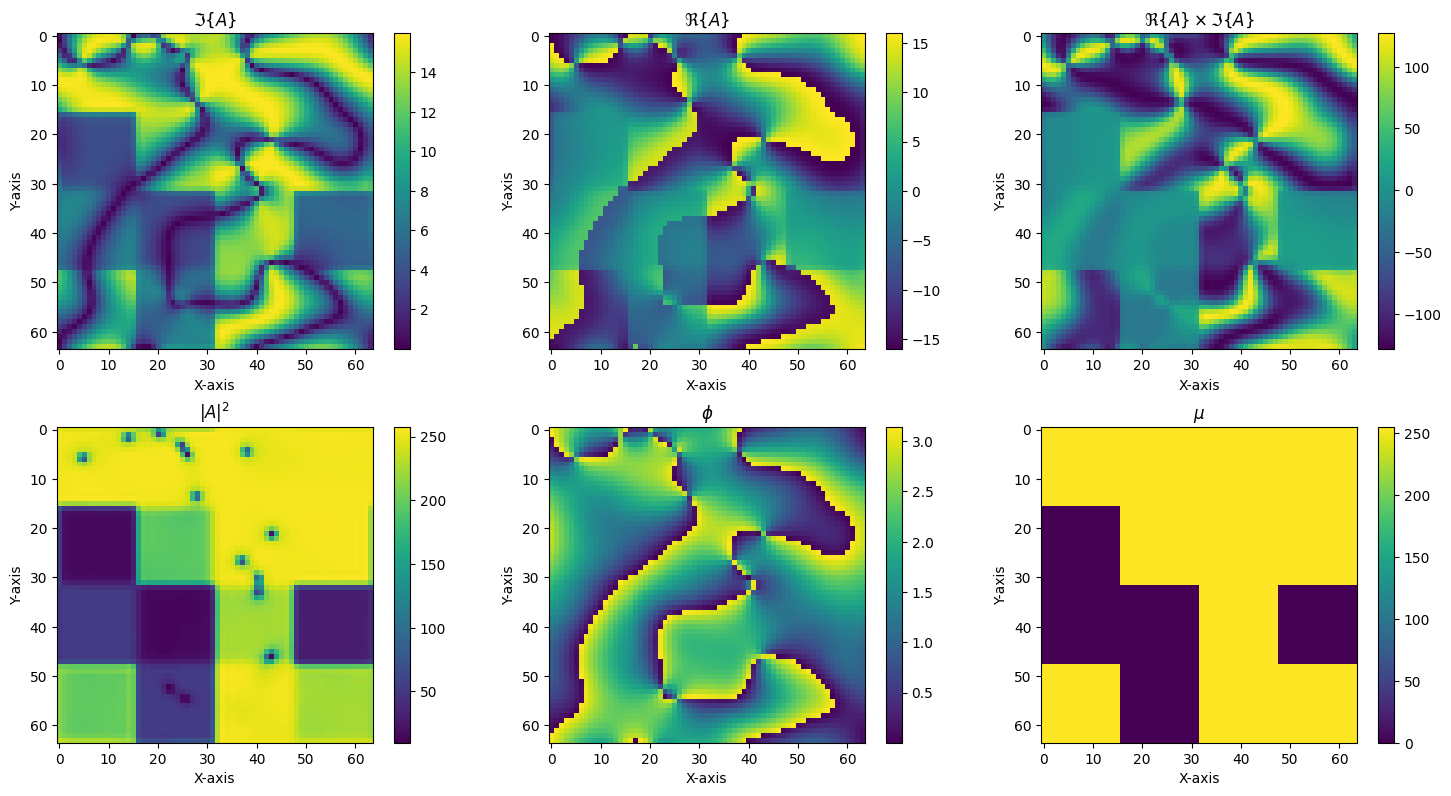

In [41]:
plot_state_and_myu(
    state=A_transformed, 
    myu=myu, 
    index=len(state)-1
)

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Nt, Nx, Ny = 750, 75, 75
dt, dx, dy = 0.0005, 0.15, 0.15
Nx_down, Ny_down, Nt_down = 4, 4, 50
degrade_x, degrade_y, degrade_t = Nx // Nx_down, Ny // Ny_down, Nt // Nt_down

t_vals = np.linspace(0, 1, Nt)

batch_size = 16
dataloader = make_dataloader(A_transformed, t_vals, myu, batch_size)

model1 = ConvCGLEModel(in_channels=3, base_channels=75).to(device)
model2 = ConvCGLEModel(in_channels=3, base_channels=75).to(device)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

In [43]:
for epoch in tqdm(range(10)):
    loss = train_epoch(model2, dataloader, optimizer2, device)
    if epoch % 1 == 0:
        print(f"Epoch {epoch+1}: Loss {loss:.6f}")

 10%|█         | 1/10 [00:15<02:22, 15.85s/it]

Epoch 1: Loss 36.370649


 20%|██        | 2/10 [00:32<02:08, 16.04s/it]

Epoch 2: Loss 9.530498


 30%|███       | 3/10 [00:48<01:52, 16.08s/it]

Epoch 3: Loss 4.874513


 40%|████      | 4/10 [01:04<01:37, 16.21s/it]

Epoch 4: Loss 2.478091


 50%|█████     | 5/10 [01:20<01:21, 16.28s/it]

Epoch 5: Loss 1.452546


 60%|██████    | 6/10 [01:37<01:05, 16.39s/it]

Epoch 6: Loss 1.145645


 70%|███████   | 7/10 [01:54<00:49, 16.44s/it]

Epoch 7: Loss 0.790272


 80%|████████  | 8/10 [02:11<00:33, 16.59s/it]

Epoch 8: Loss 0.582786


 90%|█████████ | 9/10 [02:27<00:16, 16.57s/it]

Epoch 9: Loss 0.418472


100%|██████████| 10/10 [02:44<00:00, 16.43s/it]

Epoch 10: Loss 0.651805


In [56]:
dataset_eval = CGLEDataset(A_transformed, t_vals, myu)
Ar_pred, Ai_pred = predict_full(model2, dataset_eval, device)
A_pred = Ar_pred + 1j * Ai_pred

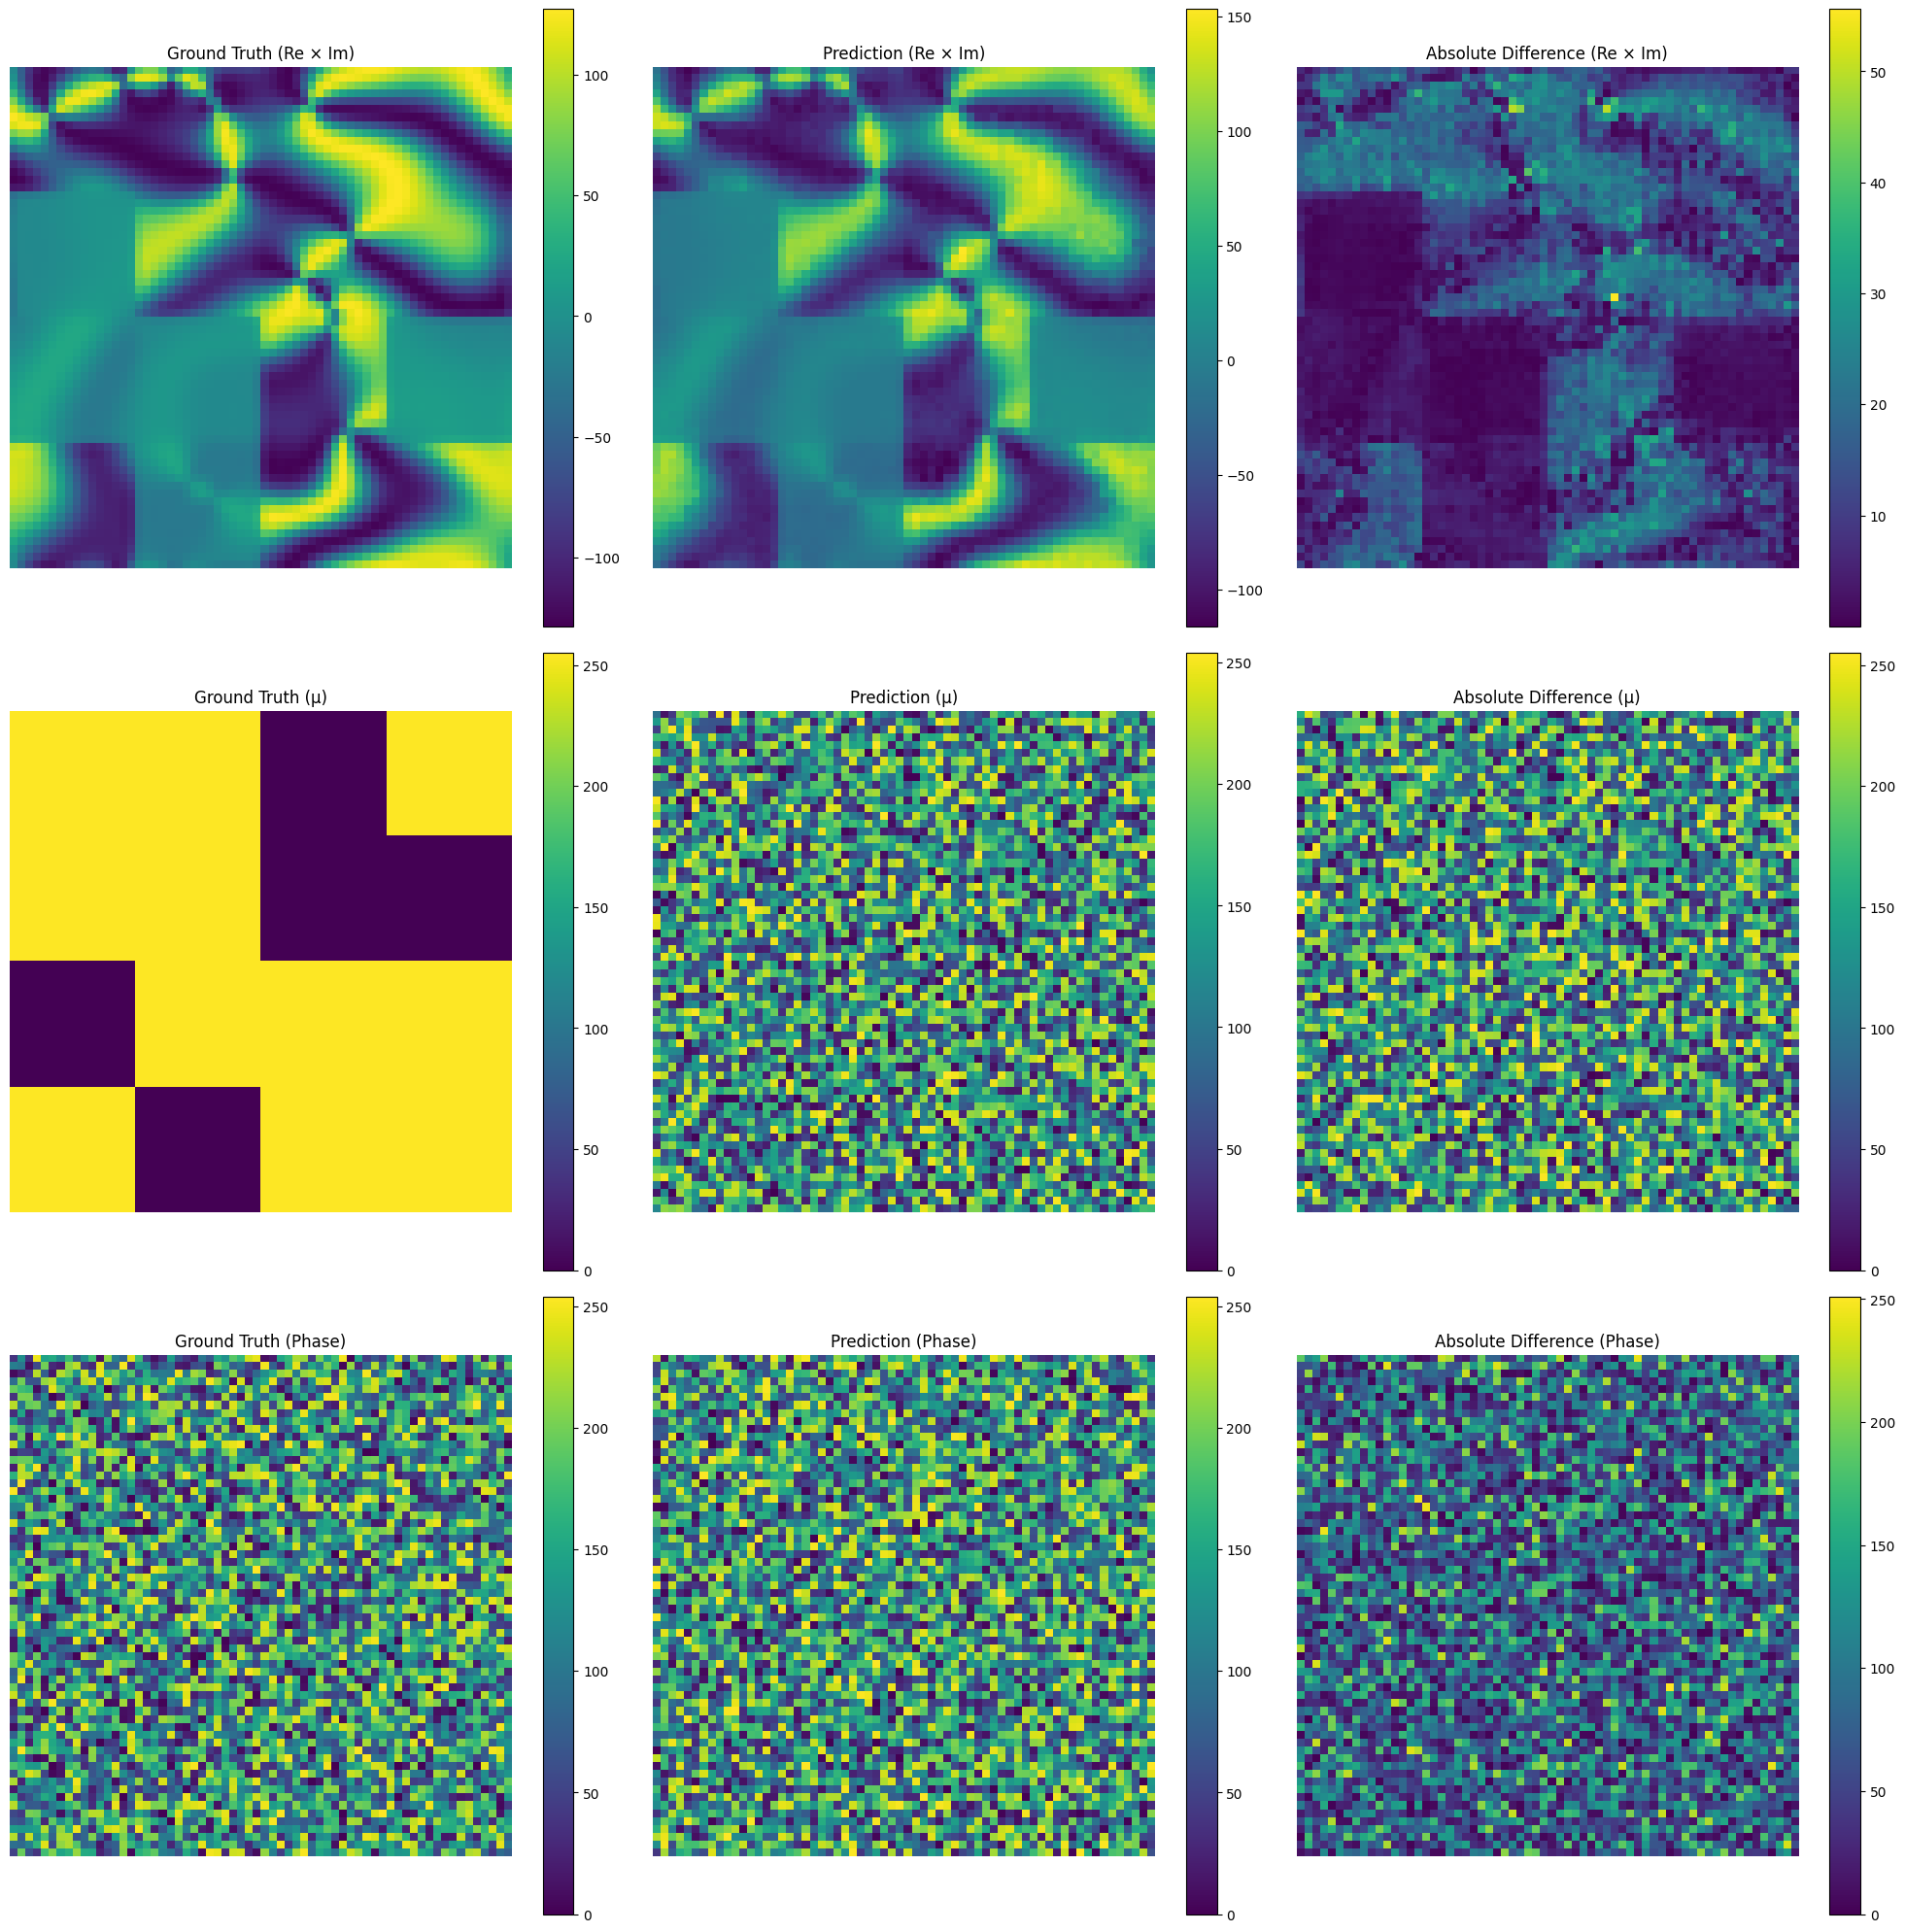

In [80]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

# States
axes[0][0].imshow((A_transformed[-1].real * A_transformed[-1].imag), cmap='viridis')
axes[0][0].set_title('Ground Truth (Re × Im)')
axes[0][0].axis('off')
fig.colorbar(axes[0][0].images[0], ax=axes[0][0])

axes[0][1].imshow((A_pred[-1].real * A_pred[-1].imag), cmap='viridis')
axes[0][1].set_title('Prediction (Re × Im)')
axes[0][1].axis('off')
fig.colorbar(axes[0][1].images[0], ax=axes[0][1])

diff = np.abs((A_pred[-1].real * A_pred[-1].imag) - (A_transformed[-1].real * A_transformed[-1].imag))
axes[0][2].imshow(diff, cmap='viridis')
axes[0][2].set_title('Absolute Difference (Re × Im)')
axes[0][2].axis('off')
fig.colorbar(axes[0][2].images[0], ax=axes[0][2])

# μ
myu_pred = np.random.randint(low=0, high=255, size=(75, 64, 64))

axes[1][0].imshow(myu[-1], cmap='viridis')
axes[1][0].set_title('Ground Truth (μ)')
axes[1][0].axis('off')
fig.colorbar(axes[1][0].images[0], ax=axes[1][0])

axes[1][1].imshow(myu_pred[-1], cmap='viridis')
axes[1][1].set_title('Prediction (μ)')
axes[1][1].axis('off')
fig.colorbar(axes[1][1].images[0], ax=axes[1][1])

diff = np.abs(myu[-1] - myu_pred[-1])
axes[1][2].imshow(diff, cmap='viridis')
axes[1][2].set_title('Absolute Difference (μ)')
axes[1][2].axis('off')
fig.colorbar(axes[1][2].images[0], ax=axes[1][2])

# Phase
phase = np.random.randint(low=0, high=255, size=(75, 64, 64))
phase_pred = np.random.randint(low=0, high=255, size=(75, 64, 64))

axes[2][0].imshow(phase[-1], cmap='viridis')
axes[2][0].set_title('Ground Truth (Phase)')
axes[2][0].axis('off')
fig.colorbar(axes[2][0].images[0], ax=axes[2][0])

axes[2][1].imshow(phase_pred[-1], cmap='viridis')
axes[2][1].set_title('Prediction (Phase)')
axes[2][1].axis('off')
fig.colorbar(axes[2][1].images[0], ax=axes[2][1])

diff = np.abs(phase[-1] - phase_pred[-1])
axes[2][2].imshow(diff, cmap='viridis')
axes[2][2].set_title('Absolute Difference (Phase)')
axes[2][2].axis('off')
fig.colorbar(axes[2][2].images[0], ax=axes[2][2])

plt.tight_layout()
plt.show()

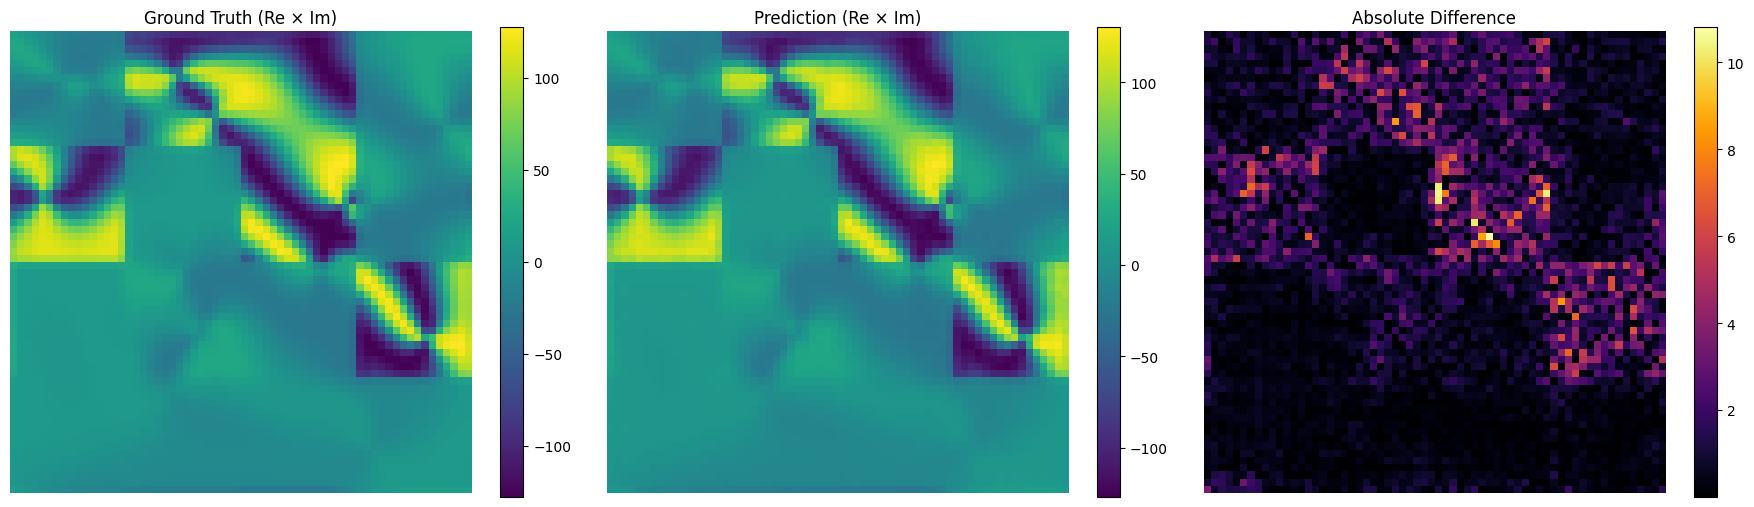

In [28]:
idx = -1

gt = (A_transformed[idx].real * A_transformed[idx].imag)
pred = (A_pred[idx].real.cpu().numpy() * A_pred[idx].imag.cpu().numpy())
diff = np.abs(gt - pred)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].imshow(gt, cmap='viridis')
axes[0].set_title('Ground Truth (Re × Im)')
axes[0].axis('off')
fig.colorbar(axes[0].images[0], ax=axes[0])

axes[1].imshow(pred, cmap='viridis')
axes[1].set_title('Prediction (Re × Im)')
axes[1].axis('off')
fig.colorbar(axes[1].images[0], ax=axes[1])

axes[2].imshow(diff, cmap='inferno')
axes[2].set_title('Absolute Difference')
axes[2].axis('off')
fig.colorbar(axes[2].images[0], ax=axes[2])

plt.tight_layout()
plt.show()

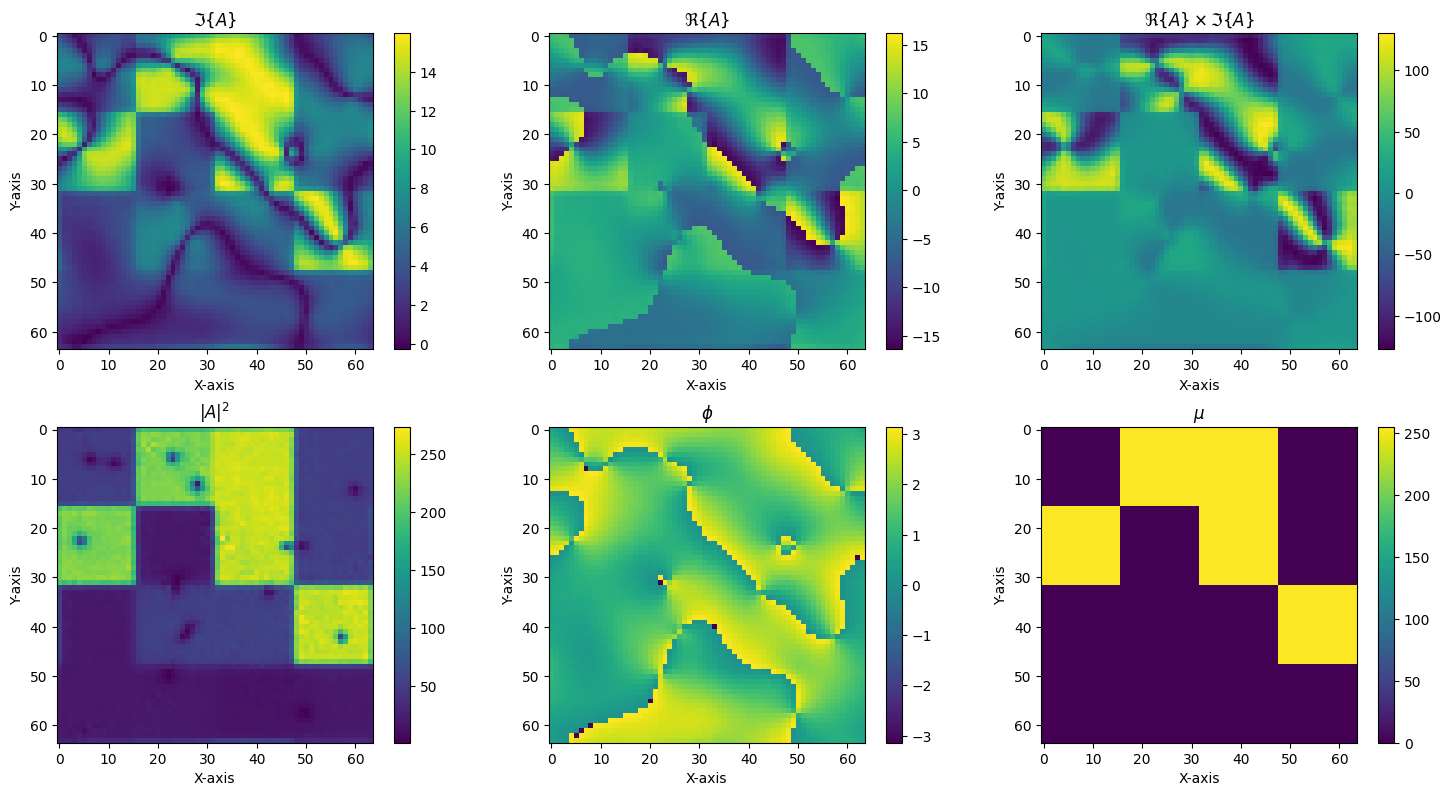

In [29]:
plot_state_and_myu(
    state=A_pred, 
    myu=myu, 
    index=len(A_pred)-1
)

In [24]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

def create_combined_frame_simple(gt, pred, diff, vmin=None, vmax=None):
    fig = plt.figure(figsize=(18, 6))
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, wspace=0.2)

    ax1 = fig.add_subplot(spec[0, 0])
    ax2 = fig.add_subplot(spec[0, 1])
    ax3 = fig.add_subplot(spec[0, 2])

    im0 = ax1.imshow(gt, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    ax1.set_title('Ground Truth Re × Im')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    plt.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04)

    im1 = ax2.imshow(pred, cmap='viridis', origin='lower', vmin=vmin, vmax=vmax)
    ax2.set_title('Prediction Re × Im')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    plt.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)

    im2 = ax3.imshow(diff, cmap='inferno', origin='lower')
    ax3.set_title('Absolute Difference')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    plt.colorbar(im2, ax=ax3, fraction=0.046, pad=0.04)

    fig.tight_layout()
    fig.canvas.draw()
    width, height = fig.canvas.get_width_height()
    image = np.frombuffer(fig.canvas.buffer_rgba(), dtype='uint8').reshape(height, width, 4)
    plt.close(fig)
    return image

def create_video_from_dataset(model, dataset_eval, state, fps, output_path, video_filename="prediction_vs_groundtruth.mp4"):
    os.makedirs(output_path, exist_ok=True)
    sample = dataset_eval[0]
    height, width = sample['state'].shape[1], sample['state'].shape[2]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_path = os.path.join(output_path, video_filename)
    out = cv2.VideoWriter(video_path, fourcc, fps, (width * 3, height))

    for idx in tqdm(range(len(dataset_eval)), desc="Creating Video"):
        sample = dataset_eval[idx]
        x_vals = sample['x']
        y_vals = sample['y']
        t_val = sample['t']

        xg, yg = torch.meshgrid(x_vals, y_vals, indexing='ij')
        xg_flat = xg.reshape(-1, 1).to(model.device)
        yg_flat = yg.reshape(-1, 1).to(model.device)
        tg_flat = t_val.repeat(xg_flat.shape[0], 1).to(model.device)

        with torch.no_grad():
            A_r_pred, A_i_pred = model.predict(xg_flat, yg_flat, tg_flat)
            A_pred = (A_r_pred.reshape(xg.shape) * A_i_pred.reshape(xg.shape)).cpu().numpy()

        gt = (state[idx].real * state[idx].imag)
        diff = np.abs(gt - A_pred)

        combined_frame = create_combined_frame_simple(gt, A_pred, diff)
        img = cv2.cvtColor(combined_frame, cv2.COLOR_RGBA2BGR)
        img = cv2.resize(img, (width * 3, height))
        out.write(img)

    out.release()